In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

In [ ]:
torch.cuda.empty_cache()

In [ ]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [15]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_rol_ht_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_ht_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"
bad_pairs_path = "C:/Cours-Sorbonne/M1/Stage/src/files/bad_pairs.txt", 
to_enhance_path = "C:/Cours-Sorbonne/M1/Stage/src/files/to_enhance_pairs.txt",

if SSH:
    path_rol_ht_super_comp = "../data/rol_ht_super_compressed" 
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"
    bad_pairs_path = "./files/bad_pairs.txt"
    to_enhance_path = "./files/to_enhance_pairs.txt"

## Params

In [16]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [33]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, 
    augment_halftone=False,
    remove_bad_pairs=True, remove_to_enhance_files=True, 
    augment_test=False, use_only_rol=True, use_context=True, max_images=10000
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)

[INFO] Using ROL Dataset with 9910 images
[INFO] Loaded exsisting targets


a group of men in uniform standing in a line
a group of men in uniform abide in a strain
a black and white photo of a monument
a inkiness and ashen photo of a monument


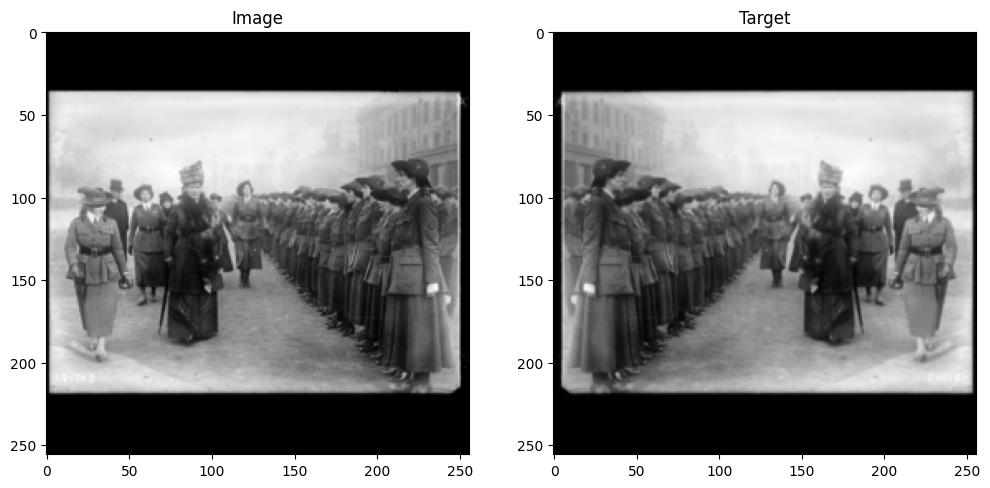

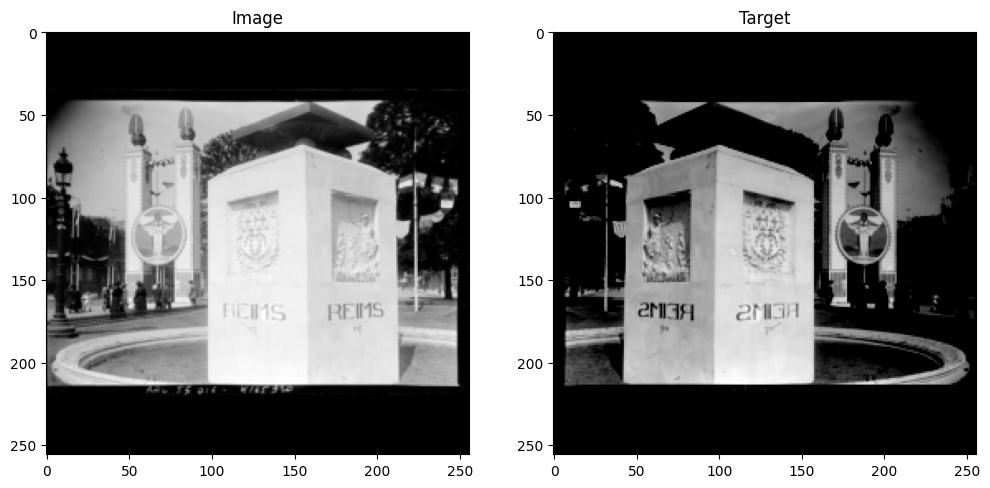

an old truck parked in front of a building
an old truck in breast of a building
a man and woman looking at dresses in a window
a man woman looking at clothe in a window


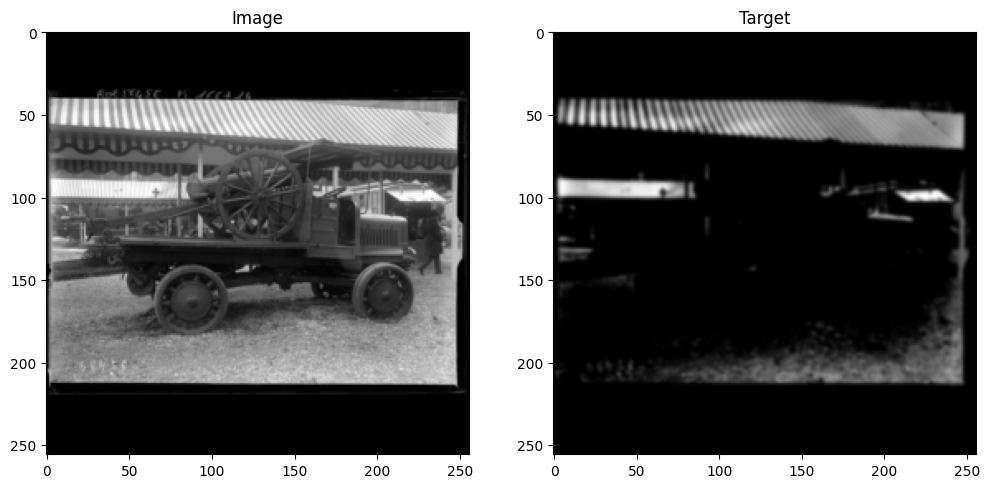

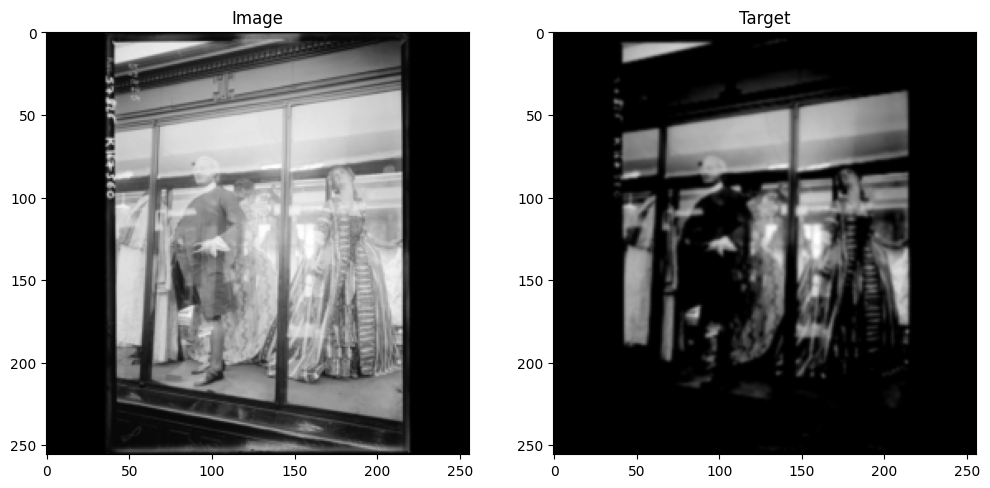

In [34]:
DSC.show_data(train_loader,2,use_context=True)
DSC.show_data(val_loader,2,use_context=True)

# Approche Supervisé

In [ ]:
model = SimCLR(feature_size=128)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

In [ ]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-128") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs, sim_clr=True, use_context=True
)

In [ ]:
trainer.save("model_simclr.pth","history_simclr.txt")

## Testing

In [13]:
testset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, augment_halftone=False,
    use_only_rol=False, augment_test=True, remove_bad_pairs=True, remove_to_enhance_files=True
)

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokeni

[INFO] Loaded exsisting targets
[INFO] Before filtering : 1926 images
[INFO] After filtering : 1337 images


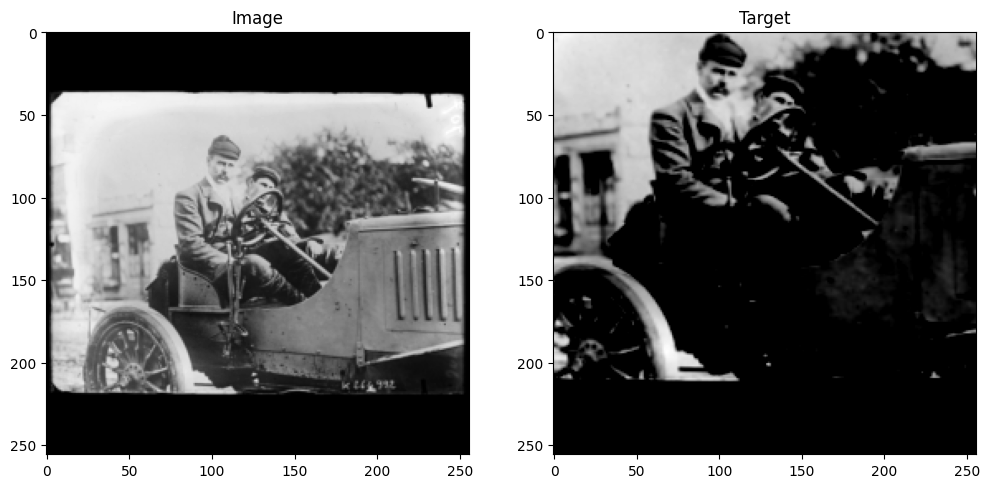

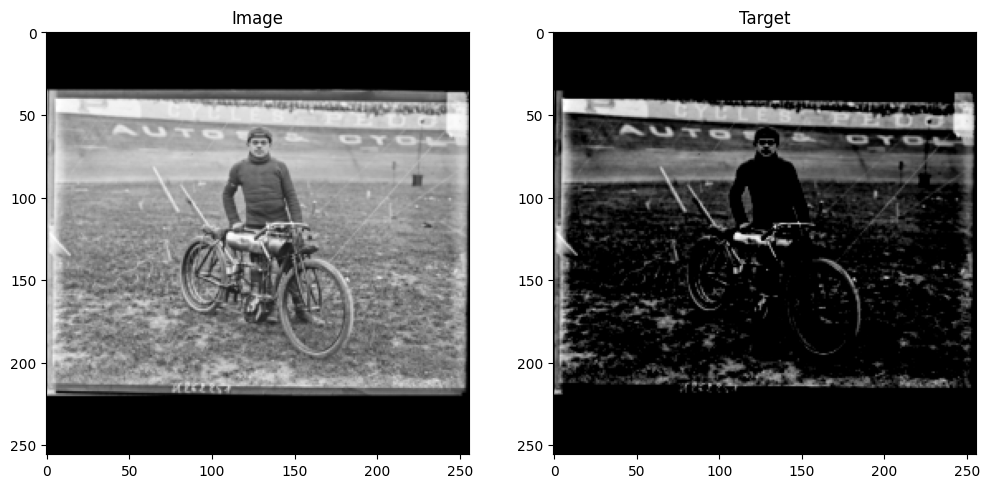

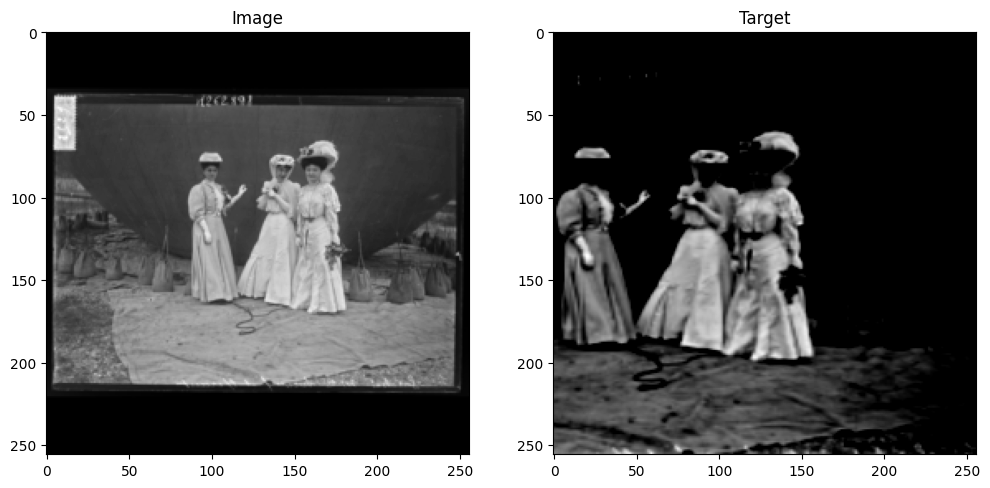

In [14]:
test_loader = DataLoader(testset, batch_size=8, shuffle=True)
DSC.show_data(test_loader, 3)

In [ ]:
model = SimCLR(feature_size=128)
model_state = Trainer().get_model("./params/model/model_simclr.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("./params/model/history_simclr.txt")

In [ ]:
top_k_pairs, original_images, augmented_images = SMY.match_images_with_simCLR(model, test_loader=test_loader, use_context=False)

In [ ]:
best_pairs = top_k_pairs[:,0]
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=10)